In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/airbnb-recruiting-new-user-bookings/sample_submission_NDF.csv.zip
/kaggle/input/airbnb-recruiting-new-user-bookings/age_gender_bkts.csv.zip
/kaggle/input/airbnb-recruiting-new-user-bookings/test_users.csv.zip
/kaggle/input/airbnb-recruiting-new-user-bookings/countries.csv.zip
/kaggle/input/airbnb-recruiting-new-user-bookings/sessions.csv.zip
/kaggle/input/airbnb-recruiting-new-user-bookings/train_users_2.csv.zip


## Importing important libraries

In [2]:
# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# Data types manipulation
from datetime import datetime

# Machine learning Modeliing
from sklearn.preprocessing import LabelEncoder
from xgboost.sklearn import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

## Importing Data

In [3]:
train_data= pd.read_csv('/kaggle/input/airbnb-recruiting-new-user-bookings/train_users_2.csv.zip')
test_data= pd.read_csv('/kaggle/input/airbnb-recruiting-new-user-bookings/test_users.csv.zip')
sample_submission= pd.read_csv('/kaggle/input/airbnb-recruiting-new-user-bookings/sample_submission_NDF.csv.zip')

In [4]:
sessions = pd.read_csv('/kaggle/input/airbnb-recruiting-new-user-bookings/sessions.csv.zip')
sessions.rename(columns = {'user_id': 'id'}, inplace=True)
sessions.head()

,id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


## Data Exploration

In [5]:
train_data.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


# numerical and categorical cols

In [6]:
num_cols = list(set(train_data.describe().columns) - set(['id']))
cat_cols = list(set(train_data.columns) - set(num_cols) - set(['id']))

In [7]:
print("The shape of training data is: ",train_data.shape)
print("The shape of testing data is: ",test_data.shape)

The shape of training data is:  (213451, 16)
The shape of testing data is:  (62096, 15)


In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       213451 non-null  object 
 1   date_account_created     213451 non-null  object 
 2   timestamp_first_active   213451 non-null  int64  
 3   date_first_booking       88908 non-null   object 
 4   gender                   213451 non-null  object 
 5   age                      125461 non-null  float64
 6   signup_method            213451 non-null  object 
 7   signup_flow              213451 non-null  int64  
 8   language                 213451 non-null  object 
 9   affiliate_channel        213451 non-null  object 
 10  affiliate_provider       213451 non-null  object 
 11  first_affiliate_tracked  207386 non-null  object 
 12  signup_app               213451 non-null  object 
 13  first_device_type        213451 non-null  object 
 14  firs

# Some Notes from the datatypes of the columns
## Columns like : 
## 1. date_account_created  , 
## 2.                timestamp_first_active    ,

## =========> Are dates but not in the date format 
# The solution 
## We will transform their types into datetime

In [9]:
# Converting the timestamps
# Convert in the training 
train_data['date_account_created'] = pd.to_datetime(train_data['date_account_created'])
train_data['date_first_booking'] = pd.to_datetime(train_data['date_first_booking'])
train_data['timestamp_first_active'] = pd.to_datetime(train_data['timestamp_first_active'], format='%Y%m%d%H%M%S')

# Convert in the training 
test_data['date_account_created'] = pd.to_datetime(test_data['date_account_created'])
test_data['date_first_booking'] = pd.to_datetime(test_data['date_first_booking'])
test_data['timestamp_first_active'] = pd.to_datetime(test_data['timestamp_first_active'], format='%Y%m%d%H%M%S')

## Investigating the Null Values

In [10]:
train_data.isnull().sum()/len(train_data)

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

Date first booking null value percentage :  58.34734904029496 %

Age null value percentage :  41.222575673105304 %

first_affiliate_tracked null value percentage :  2.84140153946339 %



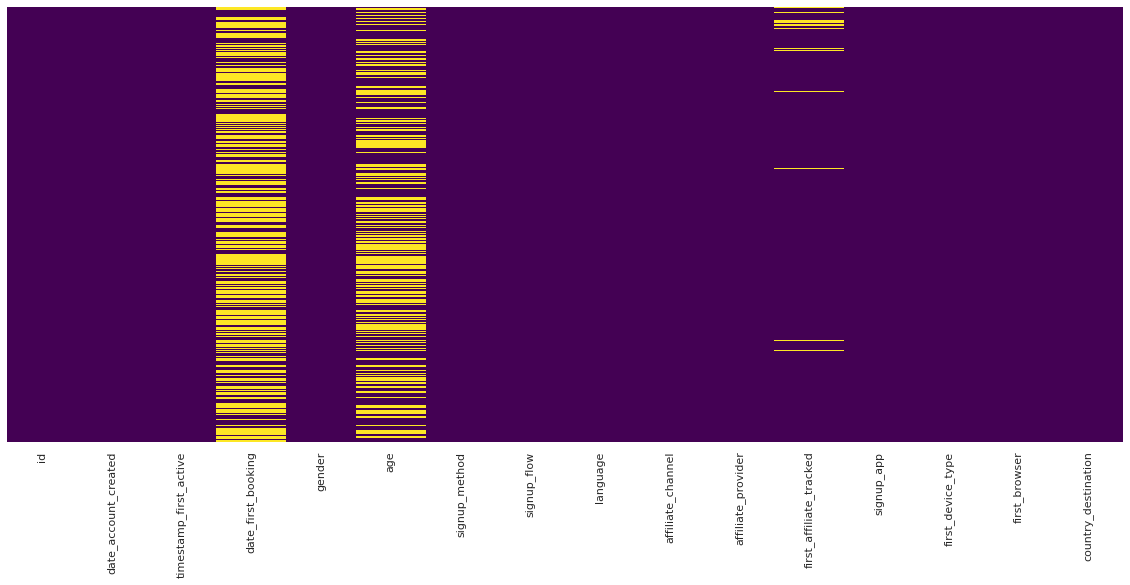

In [11]:
#Null value Analysis percejtage
plt.figure(figsize = (20,8))
sns.heatmap(train_data.isnull(),yticklabels=False,cbar=False,cmap='viridis')
train_data.isnull().sum()

print('Date first booking null value percentage : ',(train_data['date_first_booking'].isnull().sum()/len(train_data['date_first_booking'].isnull())*100),'%\n')
print('Age null value percentage : ',(train_data['age'].isnull().sum()/len(train_data['age'].isnull())*100),'%\n')
print('first_affiliate_tracked null value percentage : ',(train_data['first_affiliate_tracked'].isnull().sum()/len(train_data['first_affiliate_tracked'].isnull())*100),'%\n')

# Those Columns has high Nulls percentage :
## date_first_booking         0.583473  =====> this col will be dropped at the modelling stage
## age                        0.412226

# Exploring numerical Cols
## strat with the age col

In [12]:
print("the minimum age is",train_data.age.min())
print("the maximum age is" , train_data.age.max())

the minimum age is 1.0
the maximum age is 2014.0


## Those Values are impossible to be TRUE 
## These are entered incorrect by the users


In [13]:
(train_data.age == 2014).value_counts()

False    212741
True        710
Name: age, dtype: int64

In [14]:
(train_data.age > 100).value_counts()

False    211106
True       2345
Name: age, dtype: int64

## There are more than 2000 customer older than 100 years

In [15]:
(train_data.age > 120).value_counts()

False    212670
True        781
Name: age, dtype: int64

count    125461.000000
mean         49.668335
std         155.666612
min           1.000000
25%          28.000000
50%          34.000000
75%          43.000000
max        2014.000000
Name: age, dtype: float64


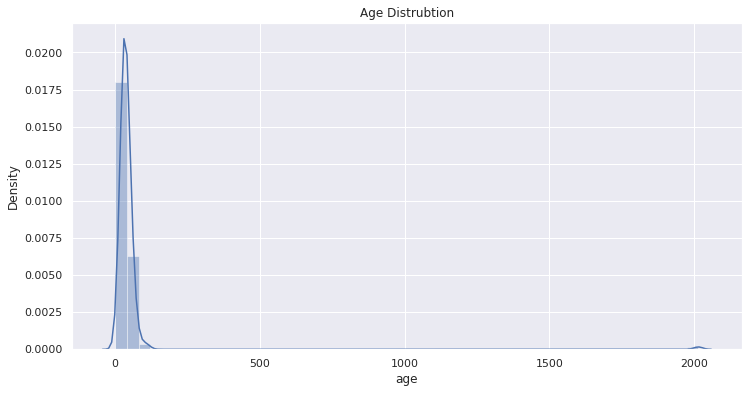

In [16]:
print(train_data['age'].describe())

plt.figure(figsize=(12,6))
sns.distplot(train_data.age.dropna())
plt.title('Age Distrubtion')
plt.show()

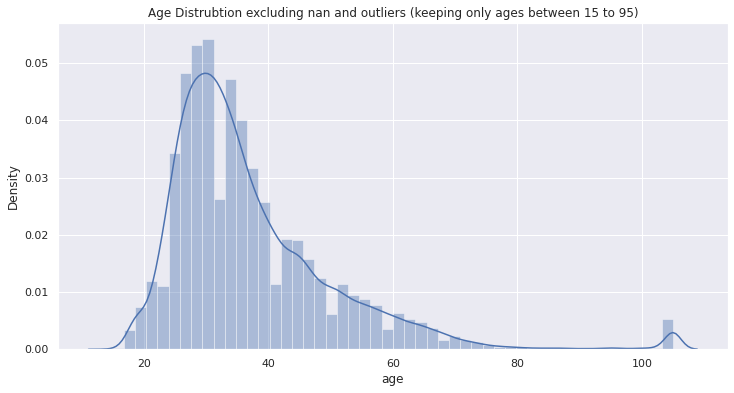

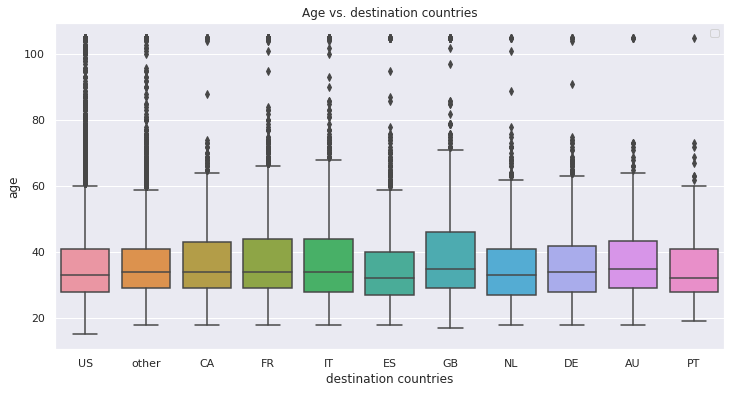

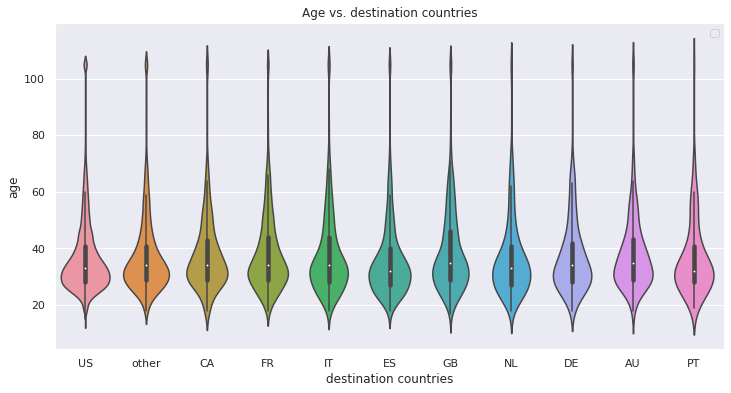

In [17]:
#Excluding nan, less than 15 and grater than 95 values
data_a = train_data
data_a.loc[(train_data.age > 105) | (train_data.age < 15), 'age'] = np.nan
plt.figure(figsize=(12,6))
sns.distplot(data_a.age.dropna())
plt.title('Age Distrubtion excluding nan and outliers (keeping only ages between 15 to 95)')
plt.show()

data_a.loc[(train_data.age > 105) | (train_data.age < 15), 'age'] = np.nan
plt.figure(figsize=(12,6))
sns.boxplot(x='country_destination',y='age', data=data_a.dropna())
plt.xlabel('destination countries')
plt.title('Age vs. destination countries')
plt.legend()
plt.show()

data_a.loc[(train_data.age > 105) | (train_data.age < 15), 'age'] = np.nan
plt.figure(figsize=(12,6))
sns.violinplot(x='country_destination',y='age', data=data_a.dropna())
plt.xlabel('destination countries')
plt.title('Age vs. destination countries')
plt.legend()
plt.show();


In [18]:
data_a.age.describe()

count    124321.000000
mean         37.251599
std          13.492084
min          15.000000
25%          28.000000
50%          34.000000
75%          43.000000
max         105.000000
Name: age, dtype: float64

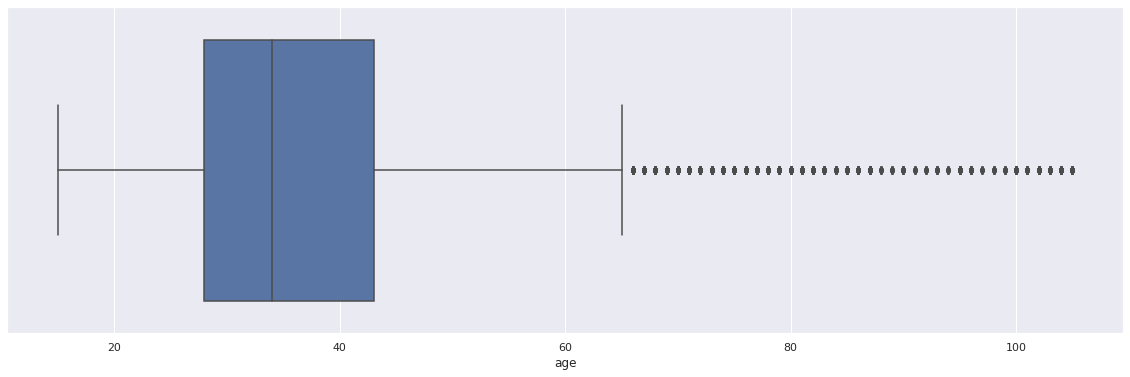

In [19]:
plt.figure(figsize = (20,6))
sns.boxplot(data_a['age']);

## Plotting Age with each destination

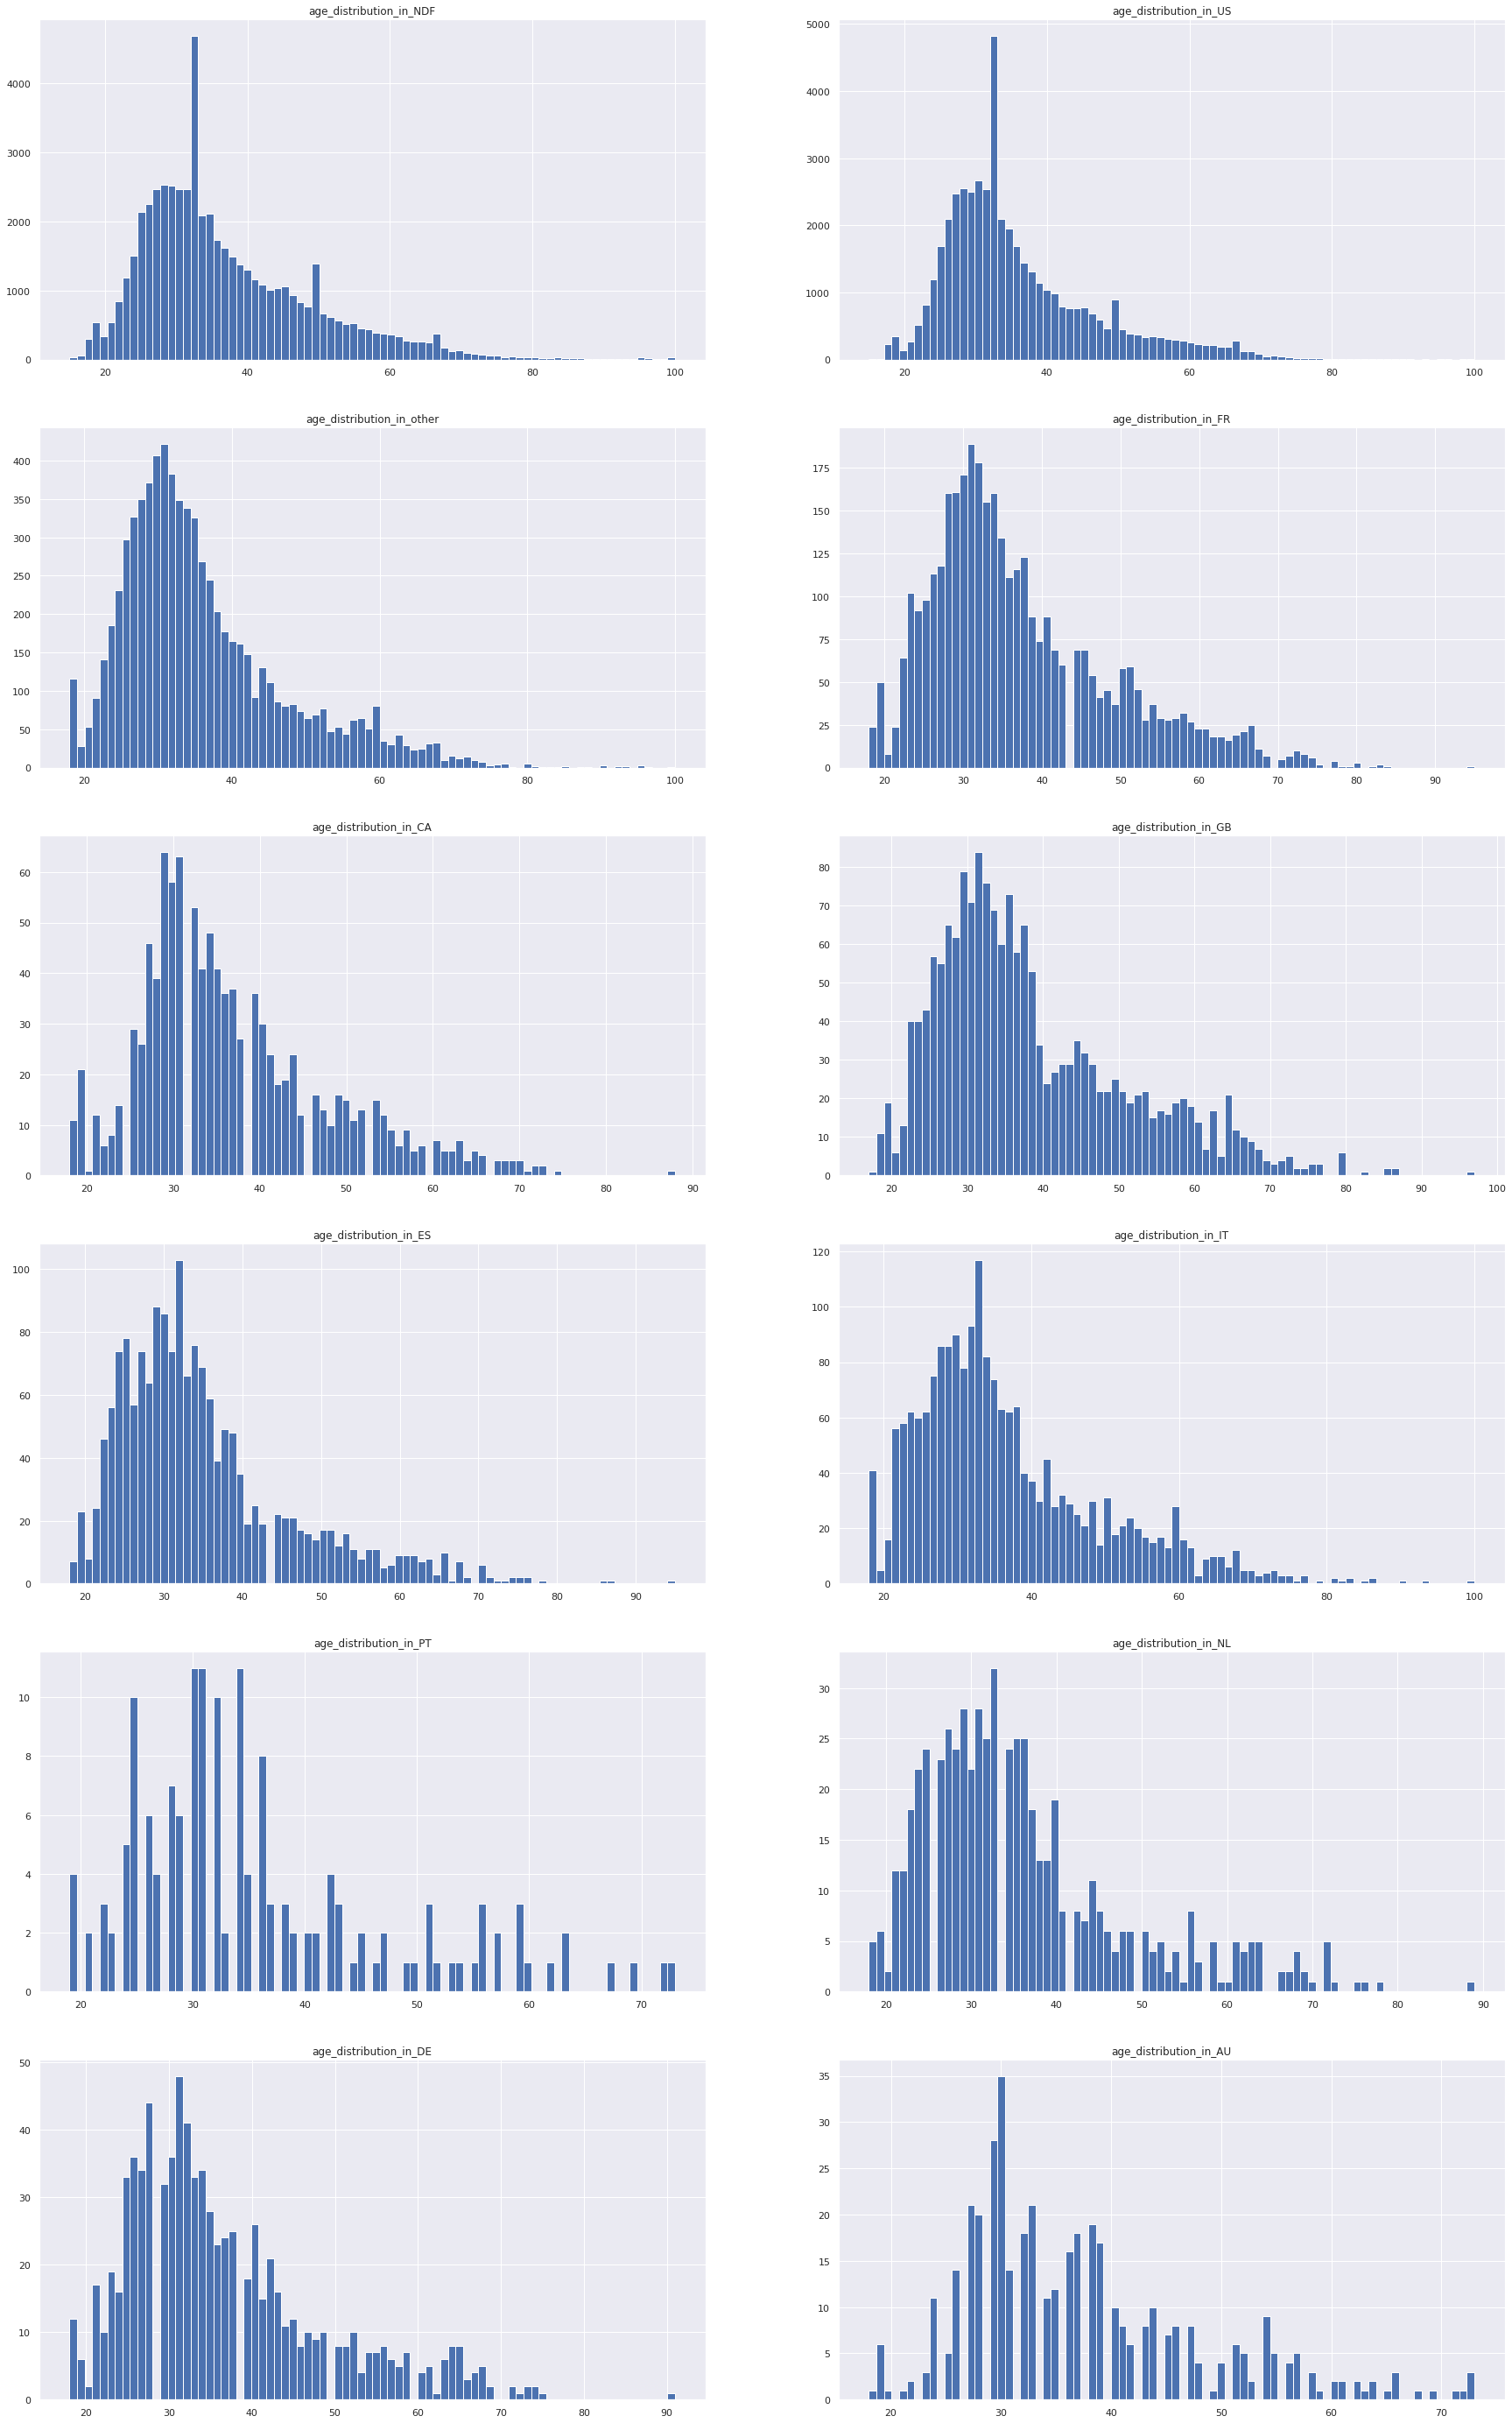

In [20]:
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(30, 50))
i=0
j=0

#for col_cnts_df_list in ls_of_column_counts_df_lists[0:2]:
for country in train_data['country_destination'].unique():
    axes[i, j].hist(train_data[(train_data['age']<=100) & (train_data['country_destination']== country)]['age'], bins=80)
    axes[i, j].set_title('age_distribution_in_{}'.format(country))
    if(j<1):
        j+=1
    else:
        i+=1
        j=0
plt.xticks()
plt.show()

## This was a trial to get an insight from age corresponding to the destination
   ### Example, The mean Avg Age to Visitors to Italy is about 37 Years old

## NL has some visitors in the Age of 90s that might be for a specific goal like medical trip

## We can see that all the distributions are right skewed with a mean around 40 


# Finding Nulls and Handle them

In [21]:
data_a.age.isnull().sum()/len(data_a)

0.41756656094372946

## Filling Nulls data in different techniques

In [22]:
# train_data['age']= train_data['age'].fillna(train_data['age'].mean())
# test_data['age']= test_data['age'].fillna(train_data['age'].mean())

In [23]:
train_data['age']= train_data['age'].fillna(train_data['age'].median())
test_data['age']= test_data['age'].fillna(train_data['age'].median())

## I choose to fill with median because it's robust with outliers 

# Exploring the categorical values

## From a high Level

In [24]:
#add colores for plot bars
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'] 

In [25]:
#Unique value analysis

print('gender : ',len(train_data[train_data['gender']!=np.nan]['gender'].unique()),'\n') # Contain unknown value

print('signup_method : ',len(train_data[train_data['signup_method']!=np.nan]['signup_method'].unique()),'\n') 

print('language : ',len(train_data[train_data['language']!=np.nan]['language'].unique()),'\n')

print('affiliate_channel : ',len(train_data[train_data['affiliate_channel']!=np.nan]['affiliate_channel'].unique()),'\n')

print('affiliate_provider : ',len(train_data[train_data['affiliate_provider']!=np.nan]['affiliate_provider'].unique()),'\n')

print('first_affiliate_tracked : ',len(train_data[train_data['first_affiliate_tracked']!=np.nan]['first_affiliate_tracked'].unique()),'\n') #Contain NAN 

print('signup_app : ',len(train_data[train_data['signup_app']!=np.nan]['signup_app'].unique()),'\n')

print('first_device_type : ',len(train_data[train_data['first_device_type']!=np.nan]['first_device_type'].unique()),'\n')

print('first_browser : ',len(train_data[train_data['first_browser']!=np.nan]['first_browser'].unique()),'\n') #-unknown-

print('signup_flow : ',len(train_data[train_data['signup_flow']!=np.nan]['signup_flow'].unique()),'\n')

print('country_destination (Target Variable) : ',len(train_data[train_data['country_destination']!=np.nan]['country_destination'].unique()),'\n')


gender :  4 

signup_method :  3 

language :  25 

affiliate_channel :  8 

affiliate_provider :  18 

first_affiliate_tracked :  8 

signup_app :  4 

first_device_type :  9 

first_browser :  52 

signup_flow :  17 

country_destination (Target Variable) :  12 



# Sign-up methods used by users

In [26]:
train_data['signup_method'].value_counts()

basic       152897
facebook     60008
google         546
Name: signup_method, dtype: int64

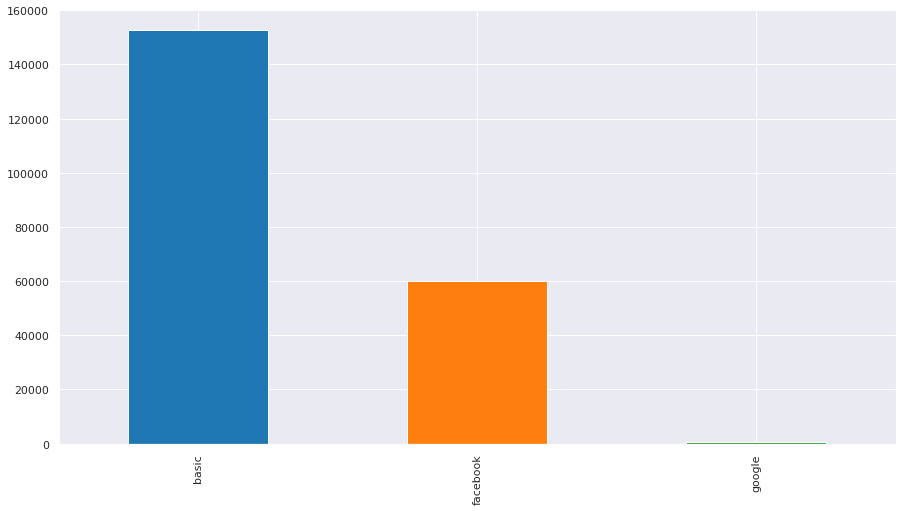

In [27]:
plt.figure(figsize = (15,8))
train_data.signup_method.value_counts(dropna=False).plot(kind='bar', color = colors);


1) Majority of users either signup from basic or facebook.

2) Basic's share is more than double of facebook.

3) Googles's share is negligible.

# Users Devices

In [28]:
train_data['first_device_type'].value_counts()

Mac Desktop           89600
Windows Desktop       72716
iPhone                20759
iPad                  14339
Other/Unknown         10667
Android Phone          2803
Android Tablet         1292
Desktop (Other)        1199
SmartPhone (Other)       76
Name: first_device_type, dtype: int64

<AxesSubplot:>

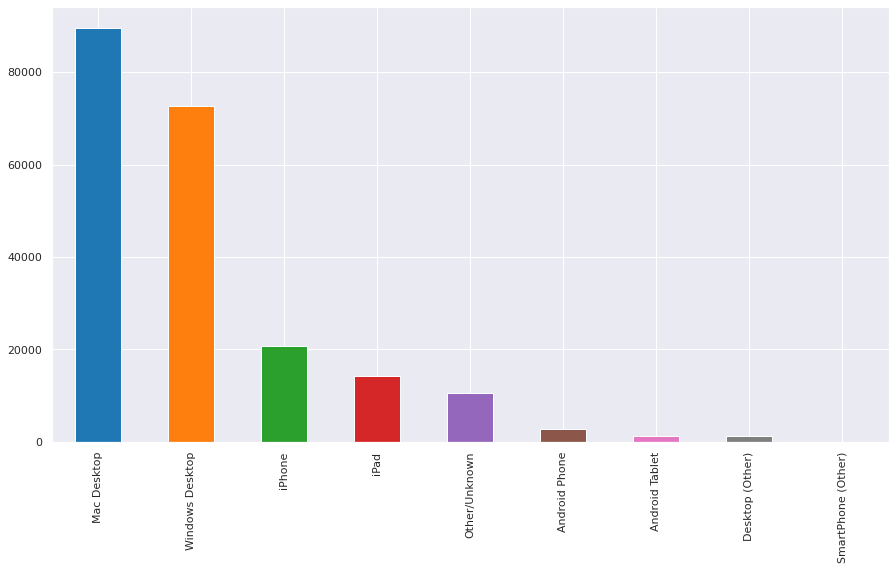

In [29]:
plt.figure(figsize = (15,8))
train_data.first_device_type.value_counts(dropna=False).plot(kind='bar', color=colors)

## Checking the output

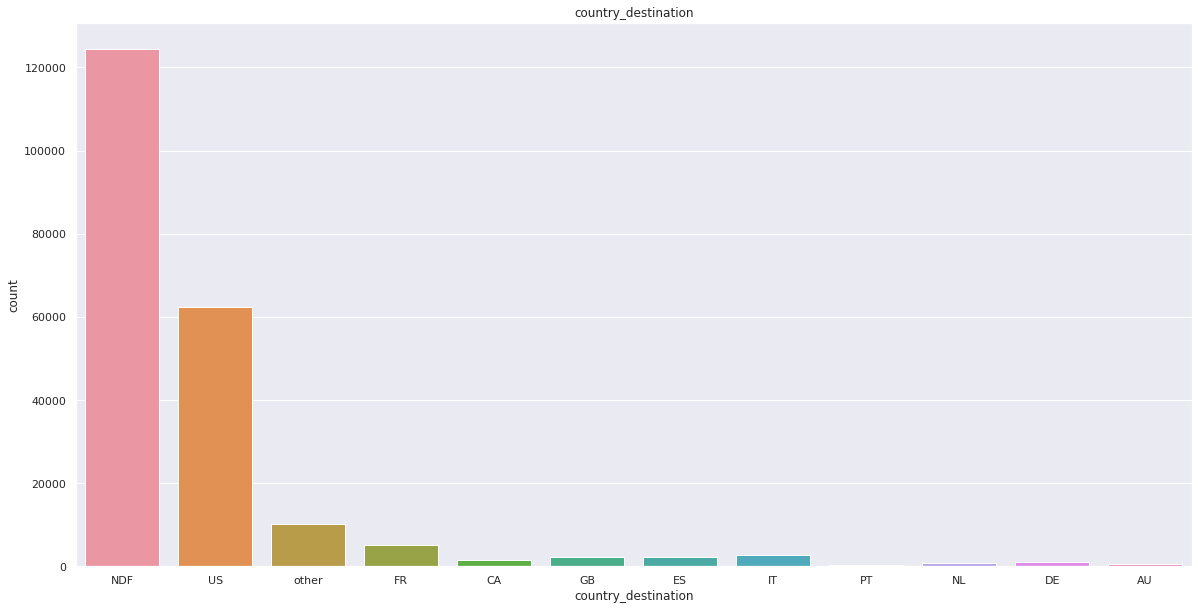

In [30]:
# destination country share

plt.figure(figsize=(20,10))

sns.set(style="darkgrid")

ax = sns.countplot(x="country_destination", data=train_data)

plt.title("country_destination")

plt.show()

1) The Dataset is highly Imbalanced.

2) Majority of users didnt do any booking or travelled to the US only.

## We can see that the output is imbalanced 
### So we will try to : Oversample using SMOTE or choosing to perform class weights

## The imbalanced datasets need special treatement in handeling and be careful at the choosing the performance metrics

# Exploring the Signup flow column

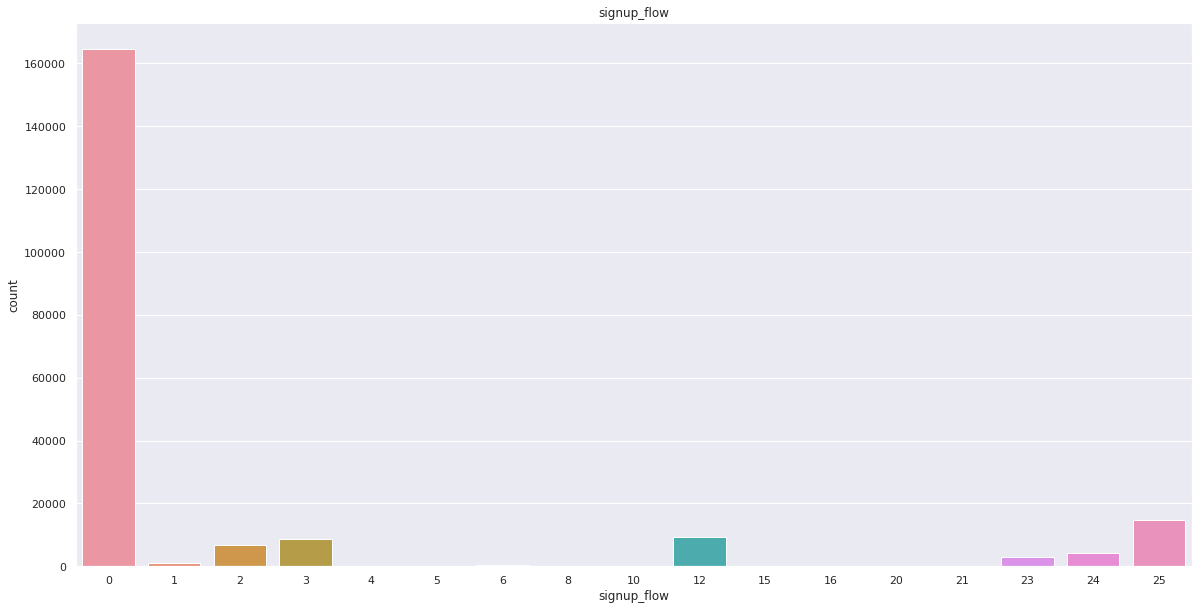

In [31]:
# signup_flow share

plt.figure(figsize=(20,10))

sns.set(style="darkgrid")

ax = sns.countplot(x="signup_flow", data=train_data)

plt.title("signup_flow")

plt.show()

1) Majority of users' signup flow is 0.

2) Other than 1,2,3,12,23,24 and 25, all others have negligible share.

# Exploring Categorical

## From low level with respect to the outliers

In [32]:
cat_list= ['gender', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser']

In [33]:
# creating a list of dataframes with aggregations between the country destinations and another categorical columns
ls_of_column_counts_df_lists= []

for column in cat_list[0:10]:
    
    grouped_tab= train_data[['country_destination', column,'id']].groupby(['country_destination', column]).count()
    grouped_tab= grouped_tab.rename(columns={'id':'{}_count'.format(column)})
    grouped_tab= grouped_tab.reset_index()
    column_counts_df_list= []
    
    for country in train_data['country_destination'].unique():
        
        grouped_tab_country= grouped_tab[grouped_tab['country_destination']== country]
        column_counts_df_list.append(grouped_tab_country)
    ls_of_column_counts_df_lists.append(column_counts_df_list)

In [34]:
ls_of_column_counts_df_lists[1][0]

,country_destination,signup_method,signup_method_count
19,NDF,basic,87846
20,NDF,facebook,36252
21,NDF,google,445


In [35]:
ls_of_column_counts_df_lists[2][0]

,country_destination,signup_flow,signup_flow_count
77,NDF,0,94845
78,NDF,1,878
79,NDF,2,3202
80,NDF,3,3207
81,NDF,4,1
82,NDF,5,34
83,NDF,6,137
84,NDF,8,129
85,NDF,10,1
86,NDF,12,6264


# Visualizing the Bivariate 

gender


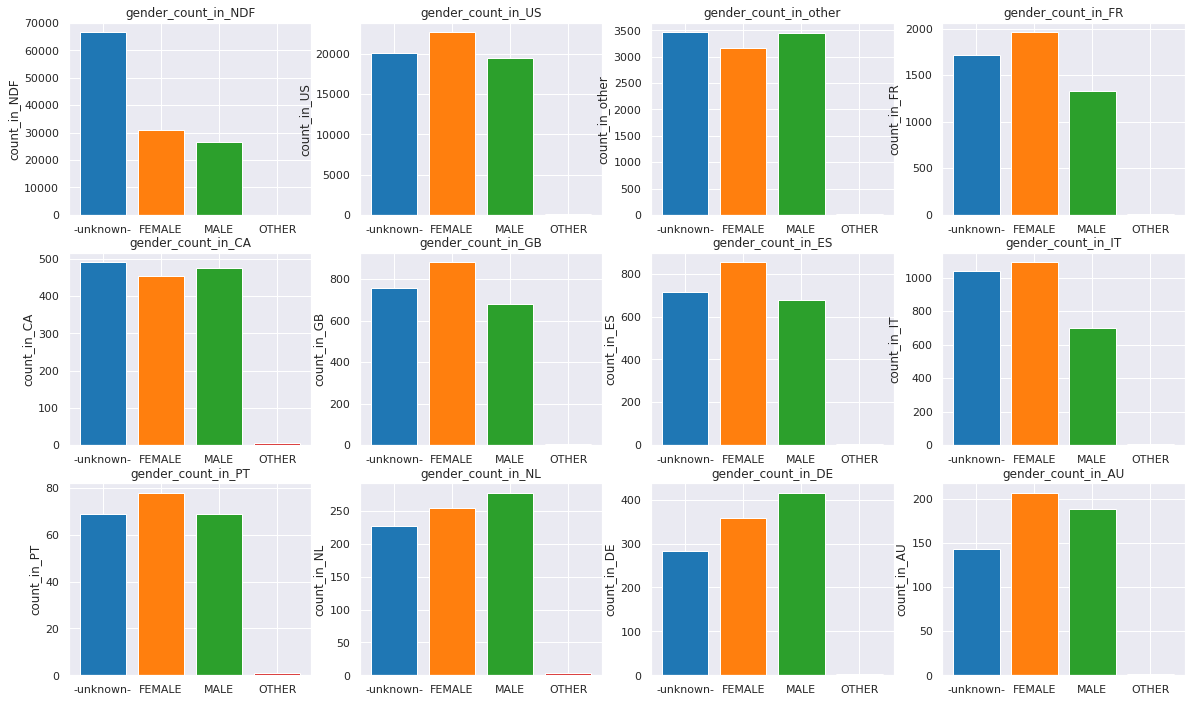

In [36]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 12))
i=0
j=0
ind=0
#for col_cnts_df_list in ls_of_column_counts_df_lists[0:2]:
for df in ls_of_column_counts_df_lists[0]:
    if len(ls_of_column_counts_df_lists[0][ind])>0:
        axes[i,j].bar(df.iloc[:, 1],df.iloc[:, 2], color =colors)
        axes[i,j].set_title('{}_count_in_'.format(df.columns[1])+ df.iloc[0, 0])
        axes[i,j].set_xlabel(''.format(df.columns[1]))
        axes[i,j].set_ylabel('count_in_{}'.format(df.iloc[0, 0]))
    if(j<3):
        j+=1
    else:
        i+=1
        j=0
    ind+=1
print(df.columns[1])
plt.xticks()
plt.show()

## I tried to extract more information as I could but from that was hard so -----> decided why not to combine all aspects in one grapgh

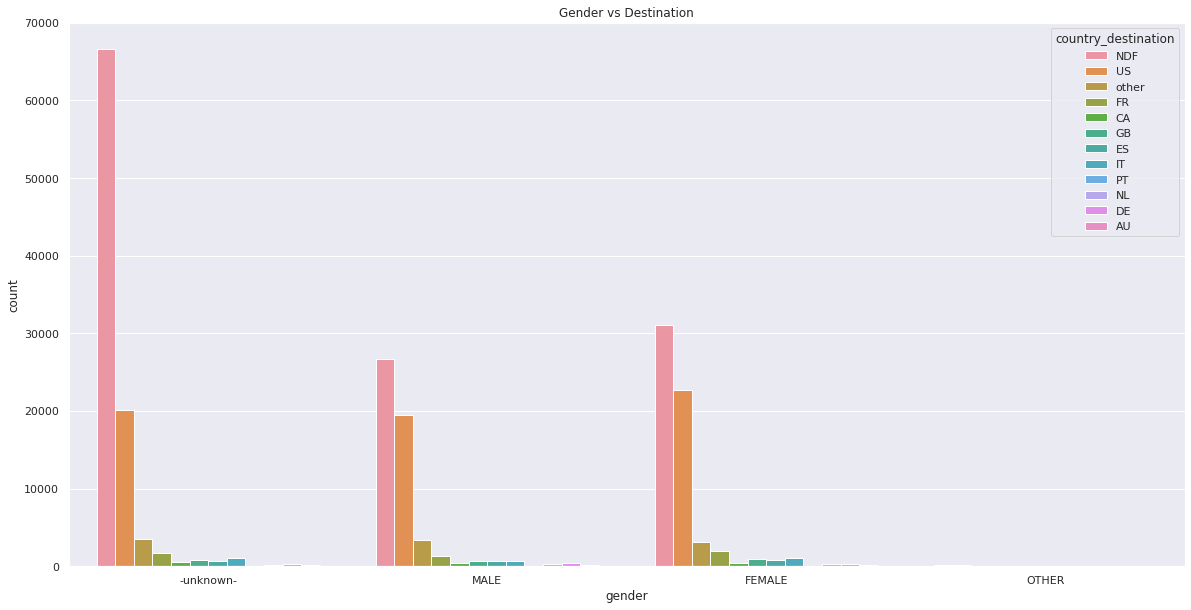

In [37]:
# gender share

plt.figure(figsize=(20,10))

sns.set(style="darkgrid")

ax = sns.countplot(x="gender", hue="country_destination", data=train_data)

plt.title("Gender vs Destination")

plt.show()

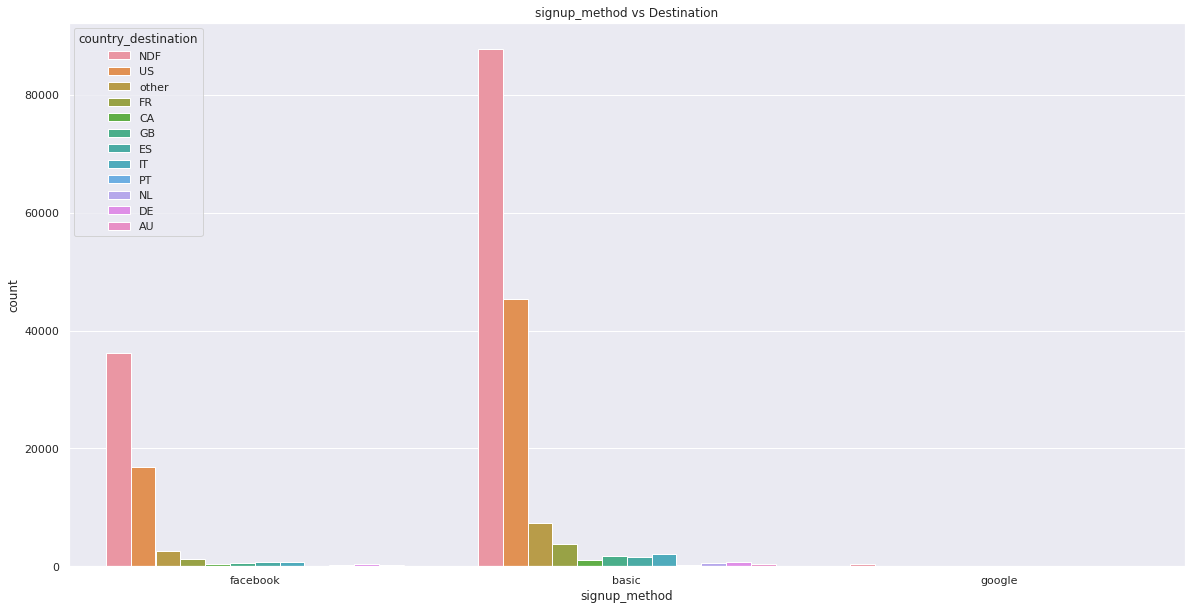

In [38]:
# signup_method share

plt.figure(figsize=(20,10))

sns.set(style="darkgrid")

ax = sns.countplot(x="signup_method", hue="country_destination", data=train_data)

plt.title("signup_method vs Destination")

plt.show()

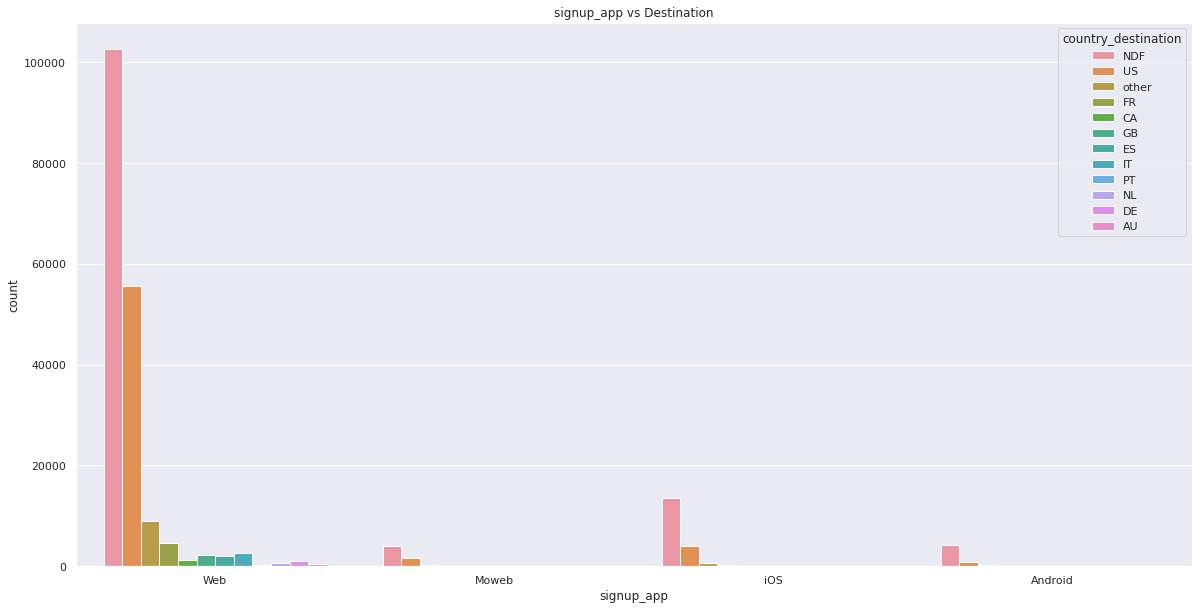

In [39]:
# signup_app share

plt.figure(figsize=(20,10))

sns.set(style="darkgrid")

ax = sns.countplot(x="signup_app", hue="country_destination", data=train_data)

plt.title("signup_app vs Destination")

plt.show()

# Generating new Features

## 1. create new feature from the subtarction of Date account created and first 

In [40]:
train_data.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,NaT,-unknown-,34.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,NaT,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [41]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   id                       213451 non-null  object        
 1   date_account_created     213451 non-null  datetime64[ns]
 2   timestamp_first_active   213451 non-null  datetime64[ns]
 3   date_first_booking       88908 non-null   datetime64[ns]
 4   gender                   213451 non-null  object        
 5   age                      213451 non-null  float64       
 6   signup_method            213451 non-null  object        
 7   signup_flow              213451 non-null  int64         
 8   language                 213451 non-null  object        
 9   affiliate_channel        213451 non-null  object        
 10  affiliate_provider       213451 non-null  object        
 11  first_affiliate_tracked  207386 non-null  object        
 12  signup_app      

In [42]:
train_data['time_btwn_created_booking'] = train_data['date_first_booking'].sub(train_data['date_account_created'], axis=0)
train_data.head(10)         

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,time_btwn_created_booking
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,NaT,-unknown-,34.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF,NaT
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,NaT,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF,NaT
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,-57 days
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,278 days
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,-208 days
5,osr2jwljor,2010-01-01,2010-01-01 21:56:19,2010-01-02,-unknown-,34.0,basic,0,en,other,other,omg,Web,Mac Desktop,Chrome,US,1 days
6,lsw9q7uk0j,2010-01-02,2010-01-02 01:25:58,2010-01-05,FEMALE,46.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US,3 days
7,0d01nltbrs,2010-01-03,2010-01-03 19:19:05,2010-01-13,FEMALE,47.0,basic,0,en,direct,direct,omg,Web,Mac Desktop,Safari,US,10 days
8,a1vcnhxeij,2010-01-04,2010-01-04 00:42:11,2010-07-29,FEMALE,50.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US,206 days
9,6uh8zyj2gn,2010-01-04,2010-01-04 02:37:58,2010-01-04,-unknown-,46.0,basic,0,en,other,craigslist,omg,Web,Mac Desktop,Firefox,US,0 days


In [43]:
train_data['time_btwn_created_booking'].describe()

count                         88908
mean     44 days 08:41:59.854231340
std      87 days 11:59:22.090141649
min             -349 days +00:00:00
25%                 1 days 00:00:00
50%                 3 days 00:00:00
75%                29 days 00:00:00
max               365 days 00:00:00
Name: time_btwn_created_booking, dtype: object

In [44]:
train_data['time_btwn_created_booking'][10].days

2

## Generating features from the datetime 
### The essentials outputs from timeseries like the Quarter and year and month ===> to gain insights about the best time they recieve new accounts and more bookings
### That might be affected by a marketing campaign that came before the increase or it is related to the consumers behavior and customers preffered some specific time in the year or quarter or month to travel new quantries and use the APP.

In [45]:
train_data['month_first_book'] = pd.DatetimeIndex(train_data['date_first_booking']).month
train_data['quarter_first_book']= pd.DatetimeIndex(train_data['date_first_booking']).quarter
train_data['year_first_book']= pd.DatetimeIndex(train_data['date_first_booking']).year
train_data['DayOfWeek_first_book']= pd.DatetimeIndex(train_data['date_first_booking']).weekday


train_data['month_account_created'] = pd.DatetimeIndex(train_data['date_account_created']).month
train_data['quarter_account_created']= pd.DatetimeIndex(train_data['date_account_created']).quarter
train_data['year_account_created']= pd.DatetimeIndex(train_data['date_account_created']).year
train_data['DayOfWeek_account_created']= pd.DatetimeIndex(train_data['date_account_created']).weekday


test_data['month_first_book'] = pd.DatetimeIndex(test_data['date_first_booking']).month
test_data['quarter_first_book']= pd.DatetimeIndex(test_data['date_first_booking']).quarter
test_data['year_first_book']= pd.DatetimeIndex(test_data['date_first_booking']).year
test_data['DayOfWeek_first_book']= pd.DatetimeIndex(test_data['date_first_booking']).weekday


test_data['month_account_created'] = pd.DatetimeIndex(test_data['date_account_created']).month
test_data['quarter_account_created']= pd.DatetimeIndex(test_data['date_account_created']).quarter
test_data['year_account_created']= pd.DatetimeIndex(test_data['date_account_created']).year
test_data['DayOfWeek_account_created']= pd.DatetimeIndex(test_data['date_account_created']).weekday



In [46]:
train_data.shape

(213451, 25)

In [47]:
train_data.isnull().sum()

id                                0
date_account_created              0
timestamp_first_active            0
date_first_booking           124543
gender                            0
age                               0
signup_method                     0
signup_flow                       0
language                          0
affiliate_channel                 0
affiliate_provider                0
first_affiliate_tracked        6065
signup_app                        0
first_device_type                 0
first_browser                     0
country_destination               0
time_btwn_created_booking    124543
month_first_book             124543
quarter_first_book           124543
year_first_book              124543
DayOfWeek_first_book         124543
month_account_created             0
quarter_account_created           0
year_account_created              0
DayOfWeek_account_created         0
dtype: int64

## 1. Visualizing Years

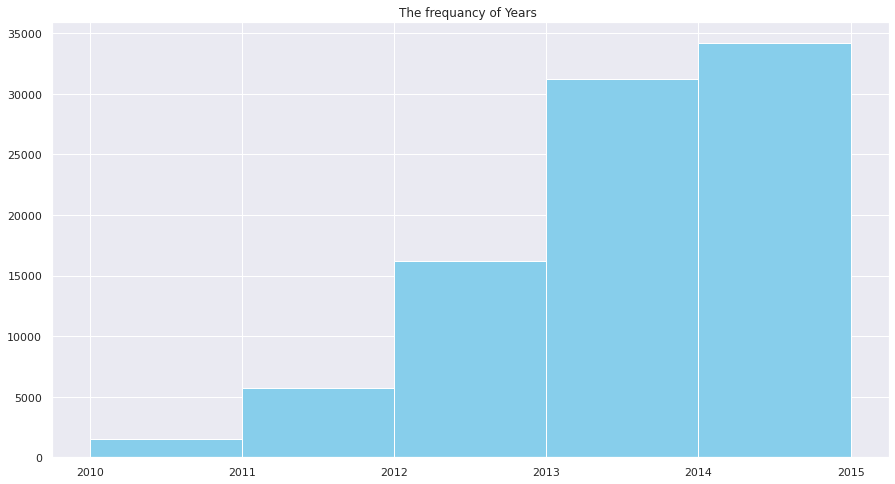

In [48]:
plt.figure(figsize = (15,8))

plt.hist(train_data['year_first_book'], color = 'skyblue', bins= 5)

plt.title("The frequancy of Years ");

## the biggest year is 2014 === > that might be because our data is until 2014

## 1. Visualizing Monthes

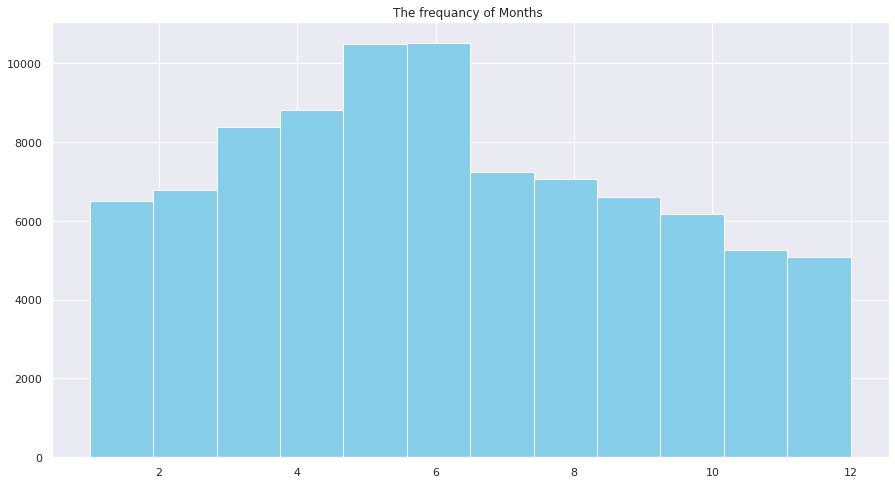

In [49]:
plt.figure(figsize = (15,8))

plt.hist(train_data['month_first_book'], color = 'skyblue', bins = 12)

plt.title("The frequancy of Months ");

## the best monthes are the mid year monthes like 4,5,6 

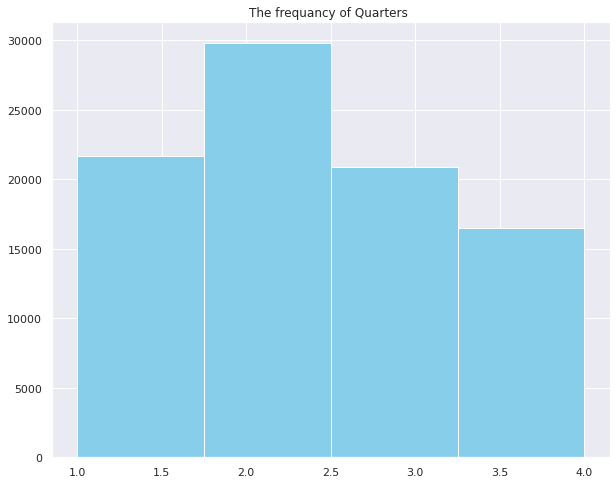

In [50]:
plt.figure(figsize = (10,8))

plt.hist(train_data['quarter_first_book'], color = 'skyblue', bins = 4)

plt.title("The frequancy of Quarters ");

## It was clear from the monthes that it's preferred by customers to make travel trips in the second Quarter monthes 4,5,6

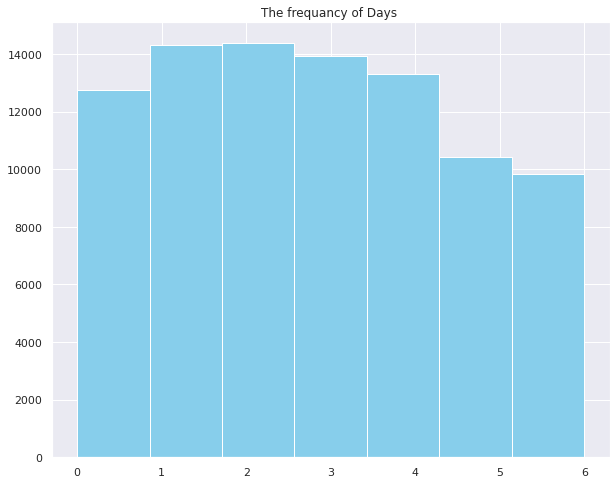

In [51]:
plt.figure(figsize = (10,8))

plt.hist(train_data['DayOfWeek_first_book'], color = 'skyblue', bins = 7)

plt.title("The frequancy of Days ");

## Filling the missing vaues in the columns generated 
### thought about median , mode
### MEdian didn't do well because it will change the datatype of the cols so decided to choose mode

In [52]:
# filling the nan values by the mode:
train_data['month_first_book']= train_data['month_first_book'].fillna(train_data['month_first_book'].mode()[0])
train_data['quarter_first_book']= train_data['quarter_first_book'].fillna(train_data['quarter_first_book'].mode()[0])
train_data['DayOfWeek_first_book']= train_data['DayOfWeek_first_book'].fillna(train_data['DayOfWeek_first_book'].mode()[0])
train_data['year_first_book']= train_data['year_first_book'].fillna(train_data['year_first_book'].mode()[0])

test_data['month_first_book']= test_data['month_first_book'].fillna(train_data['month_first_book'].mode()[0])
test_data['quarter_first_book']= test_data['quarter_first_book'].fillna(train_data['quarter_first_book'].mode()[0])
test_data['DayOfWeek_first_book']= test_data['DayOfWeek_first_book'].fillna(train_data['DayOfWeek_first_book'].mode()[0])
test_data['year_first_book']= test_data['year_first_book'].fillna(train_data['year_first_book'].mode()[0])


## Dropping datetime columns 

In [53]:
train_data.drop(columns=['date_account_created', 'timestamp_first_active', 'date_first_booking', 'time_btwn_created_booking'], inplace= True)

test_data.drop(columns=['date_account_created', 'timestamp_first_active', 'date_first_booking'], inplace= True)

# Here is the end of the EDA 

  # Let's start the Pre-processing

# Merging the train and test data

In [109]:
df = pd.concat((train_data, test_data), axis=0, ignore_index=True)

In [110]:
df.head()

,id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,...,first_browser,country_destination,month_first_book,quarter_first_book,year_first_book,DayOfWeek_first_book,month_account_created,quarter_account_created,year_account_created,DayOfWeek_account_created
0,gxn3p5htnn,-unknown-,34.0,facebook,0,en,direct,direct,untracked,Web,...,Chrome,NDF,6.0,2.0,2014.0,2.0,6,2,2010,0
1,820tgsjxq7,MALE,38.0,facebook,0,en,seo,google,untracked,Web,...,Chrome,NDF,6.0,2.0,2014.0,2.0,5,2,2011,2
2,4ft3gnwmtx,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,...,IE,US,8.0,3.0,2010.0,0.0,9,3,2010,1
3,bjjt8pjhuk,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,...,Firefox,other,9.0,3.0,2012.0,5.0,12,4,2011,0
4,87mebub9p4,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,...,Chrome,US,2.0,1.0,2010.0,3.0,9,3,2010,1


In [111]:
df.shape

(275547, 21)

In [112]:
df.columns

Index(['id', 'gender', 'age', 'signup_method', 'signup_flow', 'language',
       'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked',
       'signup_app', 'first_device_type', 'first_browser',
       'country_destination', 'month_first_book', 'quarter_first_book',
       'year_first_book', 'DayOfWeek_first_book', 'month_account_created',
       'quarter_account_created', 'year_account_created',
       'DayOfWeek_account_created'],
      dtype='object')

In [113]:
df.drop(columns=['year_first_book', 'year_account_created'], inplace= True)


In [114]:
num_cols = list(set(df.describe().columns) - set(['id']))
cat_cols = list(set(df.columns) - set(num_cols) - set(['id']))


print("numerical cols are : ", num_cols)
print("categorical cols are : ",cat_cols)

numerical cols are :  ['month_account_created', 'DayOfWeek_account_created', 'quarter_first_book', 'DayOfWeek_first_book', 'month_first_book', 'quarter_account_created', 'age', 'signup_flow']
categorical cols are :  ['first_browser', 'signup_method', 'signup_app', 'country_destination', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'first_device_type', 'language', 'gender']


In [115]:
df.dropna(axis = 0 , inplace = True)

In [116]:
df.isnull().sum()

id                           0
gender                       0
age                          0
signup_method                0
signup_flow                  0
language                     0
affiliate_channel            0
affiliate_provider           0
first_affiliate_tracked      0
signup_app                   0
first_device_type            0
first_browser                0
country_destination          0
month_first_book             0
quarter_first_book           0
DayOfWeek_first_book         0
month_account_created        0
quarter_account_created      0
DayOfWeek_account_created    0
dtype: int64

In [117]:
# # Dividing data into X and y
# X = df.drop(['country_destination'], axis = 1)
# y = df['country_destination']

In [118]:
# print(X.shape)
# print(y.shape)

# Encoding categorical

In [119]:
categorical_features = ['gender', 'signup_method', 'signup_flow', 'language','affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 
                        'first_device_type', 'first_browser']
df= pd.get_dummies(df, columns=categorical_features)


In [120]:
df.shape

(207386, 156)

In [121]:
df.set_index('id', inplace=True)

In [122]:
# Dividing data into X and y
X = df.drop(['country_destination'], axis = 1)
y = df['country_destination']


from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(y) #Transforming the target variable using labels
encoded_y

array([ 7,  7, 10, ...,  7,  7,  7])

# The numericals
## Age col needs to be standardized

# Standardizing Age

In [123]:
#Standardizing the age column:
from sklearn.preprocessing import StandardScaler

st_cols= X[['age']]
st_cols= pd.DataFrame(StandardScaler().fit_transform(st_cols), columns=['age'] )


In [124]:
X['age'] = st_cols.values

In [125]:
X['age']

id
gxn3p5htnn   -0.181704
820tgsjxq7    0.199557
4ft3gnwmtx    1.915230
bjjt8pjhuk    0.580817
87mebub9p4    0.485502
                ...   
zxodksqpep   -0.372334
mhewnxesx9   -0.181704
6o3arsjbb4   -0.372334
jh95kwisub   -0.181704
nw9fwlyb5f   -0.181704
Name: age, Length: 207386, dtype: float64

# Exploring sessions dataset

## Sessions dataset is a table saving the action , device and the time spent on the platform 
### Those data are so important to be joing with the full dataset to feed the model with much more related data

In [126]:
print(sessions.shape)
sessions.head()

(10567737, 6)


,id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


# Oversampling using smote 

## It's not recommended to use smote model in high dimentions data and 

In [127]:
# from imblearn.over_sampling import SMOTE 
# sm = SMOTE(random_state = 2)

# X1, y1 = sm.fit_resample(X, y)

# Features selection with statistical tests 
## Chi square

In [128]:
# from sklearn.feature_selection import chi2
# from sklearn.feature_selection import SelectKBest

# test = SelectKBest(score_func=chi2, k=20)
# fit = test.fit(X, y)
# fit.scores_


# Training models

# Our problem is multiclass classification
## I was thinking about using {RandomForest Classifier ==> for it's interpretability, XGboost ==> for it's multi-threading, and Tree based}

In [129]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, encoded_y, test_size=0.25, random_state=42)

In [130]:
# Modeling
from xgboost import XGBClassifier, plot_importance
xgb = XGBClassifier(use_label_encoder=False)                  
xgb.fit(X_train, y_train)

[06:55:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [131]:
param = {}
param['booster'] = 'gbtree'
param['objective'] = 'binary:logistic'
param["eval_metric"] = "error"
param['eta'] = 0.3
param['gamma'] = 0
param['max_depth'] = 6
param['min_child_weight']=1
param['max_delta_step'] = 0
param['subsample']= 1
param['colsample_bytree']=1
param['silent'] = 1
param['seed'] = 0
param['base_score'] = 0.5

clf = XGBClassifier(param)
clf.fit(X_train, y_train)

[07:03:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [132]:
y_pred2 = clf.predict_proba(X_test)

In [133]:
y_pred = xgb.predict_proba(X_test)

In [134]:
y_test[:10]

array([ 4,  4, 10,  7, 10, 10, 10,  7, 10,  7])

In [135]:
y_pred2[:10]

array([[3.63645446e-03, 1.99231487e-02, 2.19400581e-02, 7.32350200e-02,
        7.71697238e-02, 3.09037399e-02, 4.60587889e-02, 1.34319402e-04,
        2.38078330e-02, 1.25090894e-03, 5.65244079e-01, 1.36695951e-01],
       [9.79983620e-03, 1.17501346e-02, 5.19895600e-03, 1.79599784e-02,
        4.90870625e-02, 2.05501709e-02, 1.78949330e-02, 1.32154411e-04,
        1.32714235e-03, 3.80958593e-03, 6.46891057e-01, 2.15599045e-01],
       [2.16295454e-03, 2.83112191e-02, 6.55282242e-03, 4.33231033e-02,
        3.57582234e-02, 1.76148489e-02, 2.19934359e-02, 2.94234284e-04,
        5.62248100e-03, 7.93710991e-04, 7.19450474e-01, 1.18122540e-01],
       [1.47446754e-05, 7.57127491e-05, 9.76473020e-05, 1.49366679e-04,
        1.98085254e-04, 9.12575269e-05, 1.73010791e-04, 9.98113036e-01,
        3.28610440e-05, 1.48215813e-05, 7.87859259e-04, 2.51593126e-04],
       [1.20174559e-02, 1.89710762e-02, 5.25366608e-03, 4.48915595e-03,
        4.16742936e-02, 8.02468974e-03, 3.93447280e-03, 1.23

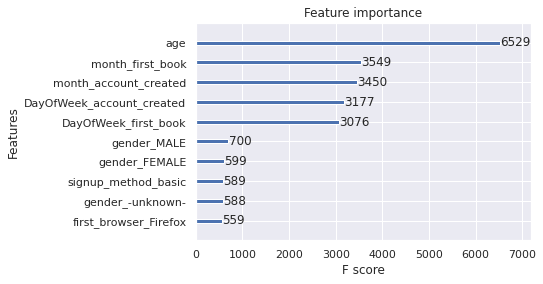

In [136]:
plot_importance(clf, max_num_features=10)
f_importances= clf.feature_importances_

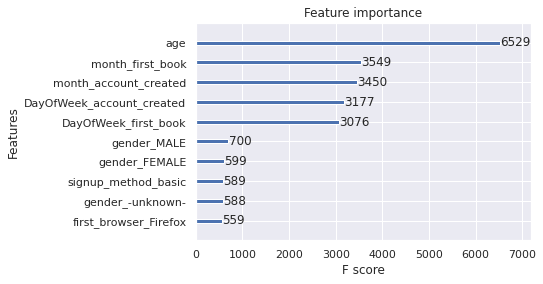

In [137]:
plot_importance(xgb, max_num_features=10)
f_importances= xgb.feature_importances_

# Testing model

In [138]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb.fit(range(12))

y_test_enc = lb.transform(y_test)


In [139]:
from sklearn import metrics
model_1_score= metrics.ndcg_score(y_true= y_test_enc,
                           y_score= y_pred2,
                           k=5, sample_weight=None, ignore_ties=False)
model_1_score

0.9221942104492034